In [2]:
import cv2
import mediapipe as mp
import numpy as np
import subprocess
import collections
import webrtcvad
import matplotlib.pyplot as plt
from pathlib import Path
from deepface import DeepFace

# --- Funcții VAD (voice activity detection) ---

In [ ]:
# Extrage audio dintr-un fișier video folosind ffmpeg
def extract_audio_ffmpeg(video_path, audio_output_path='temp_audio.wav'):
    command = [
        'ffmpeg',
        '-y',
        '-i', video_path,
        '-vn',
        '-acodec', 'pcm_s16le',
        '-ar', '16000',
        '-ac', '1',
        audio_output_path
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
# Genereaza framuri dintr-un video
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    while offset + n < len(audio):
        yield audio[offset:offset + n]
        offset += n

In [5]:
def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    triggered = False
    voiced_frames = []
    segments = []
    start_time = 0
    frame_index = 0
    for frame in frames:
        is_speech = vad.is_speech(frame, sample_rate)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                start_time = frame_index * frame_duration_ms / 1000.0
                voiced_frames.extend([f for f, s in ring_buffer])
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                end_time = frame_index * frame_duration_ms / 1000.0
                segments.append((start_time, end_time))
                ring_buffer.clear()
                voiced_frames = []
        frame_index += 1

    if triggered:
        segments.append((start_time, frame_index * frame_duration_ms / 1000.0))
    return segments

In [ ]:
# Extrage segmentele de vorbire dintr-un fișier audio folosind WebRTC VAD
def extract_speech_segments(audio_path):
    with open(audio_path, 'rb') as f:
        audio = f.read()
    sample_rate = 16000
    vad = webrtcvad.Vad(1)
    
    frames = list(frame_generator(30, audio, sample_rate))
    segments = vad_collector(sample_rate, 30, 300, vad, frames)
    return segments

# Functii de calcul scor lip-movment

In [ ]:
# Calculeaza un scor pentru mișcarea buzelor
def lip_movement_score(landmarks, prev_landmarks, frame_shape):
    lips_ids = [61, 291, 13, 14, 17, 0, 37, 267]
    anchor_ids = [1, 33, 263, 168, 2]  # puncte fixe: nas și colțuri ochi

    if landmarks is None or prev_landmarks is None:
        return 0

    # Extrage pozițiile actuale și anterioare pentru buze și ancore
    current_lips = np.array([(landmarks.landmark[i].x * frame_shape[1],
                              landmarks.landmark[i].y * frame_shape[0]) for i in lips_ids])
    prev_lips = np.array([(prev_landmarks.landmark[i].x * frame_shape[1],
                           prev_landmarks.landmark[i].y * frame_shape[0]) for i in lips_ids])

    current_anchors = np.array([(landmarks.landmark[i].x * frame_shape[1],
                                 landmarks.landmark[i].y * frame_shape[0]) for i in anchor_ids])
    prev_anchors = np.array([(prev_landmarks.landmark[i].x * frame_shape[1],
                              prev_landmarks.landmark[i].y * frame_shape[0]) for i in anchor_ids])

    # Calculează centrul de masă al punctelor de referință (ancore)
    current_center = np.mean(current_anchors, axis=0)
    prev_center = np.mean(prev_anchors, axis=0)

    # Compensează translația capului (mișcarea globală)
    corrected_lips = current_lips - (current_center - prev_center)

    # Distanța efectivă a buzelor (după corectarea mișcării capului)
    dist = np.linalg.norm(corrected_lips - prev_lips)
    return dist

In [ ]:
# Calculează variația deschiderii buzelor
def lip_opening_variation(landmarks, prev_landmarks, frame_shape):
    if landmarks is None or prev_landmarks is None:
        return 0

    # Punctele cheie (centru gurii)
    top_id = 13
    bottom_id = 14

    # Coordonate actuale
    top = np.array([landmarks.landmark[top_id].x * frame_shape[1],
                    landmarks.landmark[top_id].y * frame_shape[0]])
    bottom = np.array([landmarks.landmark[bottom_id].x * frame_shape[1],
                       landmarks.landmark[bottom_id].y * frame_shape[0]])

    # Coordonate anterioare
    prev_top = np.array([prev_landmarks.landmark[top_id].x * frame_shape[1],
                         prev_landmarks.landmark[top_id].y * frame_shape[0]])
    prev_bottom = np.array([prev_landmarks.landmark[bottom_id].x * frame_shape[1],
                            prev_landmarks.landmark[bottom_id].y * frame_shape[0]])

    # Distanțele verticale între buze (actual vs anterior)
    current_distance = np.linalg.norm(top - bottom)
    prev_distance = np.linalg.norm(prev_top - prev_bottom)

    # Diferența de deschidere gură
    return abs(current_distance - prev_distance)

In [ ]:
# Calculează un scor combinat pentru mișcarea buzelor
def combined_lip_movement_score(landmarks, prev_landmarks, frame_shape, alpha=0.7):
    movement = lip_movement_score(landmarks, prev_landmarks, frame_shape)
    opening_change = lip_opening_variation(landmarks, prev_landmarks, frame_shape)
    return alpha * opening_change + (1 - alpha) * movement

# Functii utile pentru video + testare video

In [ ]:
# Obtine bounding box-ul feței din landmarks
def get_face_bounding_box(landmarks, frame_shape):
    x_coords = [landmarks.landmark[i].x * frame_shape[1] for i in range(len(landmarks.landmark))]
    y_coords = [landmarks.landmark[i].y * frame_shape[0] for i in range(len(landmarks.landmark))]
    x_min, x_max = int(min(x_coords)), int(max(x_coords))
    y_min, y_max = int(min(y_coords)), int(max(y_coords))
    return x_min, y_min, x_max, y_max

# Functii de analiza video

In [ ]:
# Functia analizaeaza un video pentru a detecta vorbitorii și mișcarea buzelor, oferind detali despre vorbitorul principal
def analyze_video(video_path, speech_segments, face_mesh, verbose=False):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    prev_landmarks_list = [None] * 5
    lip_movement_scores = [0] * 5
    frame_idx = 0
    face_positions_per_frame = []

    exclude_frames_idx = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        time_sec = frame_idx / fps
        
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # results = face_mesh.process(cv2.cvtColor(preprocess_frame(frame), cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            face_positions_per_frame.append([None]*5)
            frame_idx += 1
            continue
        
        speaking = any(start <= time_sec <= end for (start, end) in speech_segments)
        
        current_frame_positions = []
        for i in range(5):
            current_frame_positions.append(None)
        
        for i, face_landmarks in enumerate(results.multi_face_landmarks):
            move = combined_lip_movement_score(face_landmarks, prev_landmarks_list[i], frame.shape)
            if(move > 20):
                move = 0
                exclude_frames_idx.append(frame_idx)
                
            
            prev_landmarks_list[i] = face_landmarks
            if speaking:
                lip_movement_scores[i] += move
                if(verbose):
                    print(f"Frame {frame_idx}, Face {i}, Lip Movement Score: {lip_movement_scores[i]:.2f}, moving: {move:.2f}")
            
            # Salvează bounding box față
            bbox = get_face_bounding_box(face_landmarks, frame.shape)
            current_frame_positions[i] = bbox
        
        face_positions_per_frame.append(current_frame_positions)
        frame_idx += 1
    
    cap.release()
    return lip_movement_scores, face_positions_per_frame, fps, video_path, exclude_frames_idx

# Functii de detectare emoti

In [ ]:
# Prezice emotia cu deepface
def predict_emotion(frame):
    result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
    return result[0]['dominant_emotion']


In [ ]:
# Prezice emotia din video pentru vorbitorul principal folosind analiza video si functia predict_emotion
def predict_emotions_in_video_for_speaker(video_path, face_mesh, plot_faces=False, frame_skip = 5, verbose=False):
    audio_path = 'temp_audio.wav'

    extract_audio_ffmpeg(video_path, audio_path)
    speech_segments = extract_speech_segments(audio_path)
    scores, face_positions_per_frame, fps, video_path, exclude_frames_idx = analyze_video(
        video_path, speech_segments, face_mesh, verbose=verbose)

    vorbitoarea_index = np.argmax(scores)

    if verbose:    
        print("Lip movement scores pentru fiecare față:", scores)
        print(f"Persoana care vorbește cel mai probabil este fața cu indexul: {vorbitoarea_index}")

    # Gaseste toate frame-urile valide
    valid_frames = [
        (idx, frame_faces[vorbitoarea_index])
        for idx, frame_faces in enumerate(face_positions_per_frame)
        if frame_faces[vorbitoarea_index] is not None and idx not in exclude_frames_idx
    ]

    if not valid_frames:
        print("Nu s-a găsit niciun frame valid cu fața vorbitoarei.")
        return None
    elif verbose:
        print(f"Numărul de frame-uri valide cu fața vorbitoarei: {len(valid_frames)}")
        print(f"Framuril excluse: {len(exclude_frames_idx)}")

    cap = cv2.VideoCapture(str(video_path))
    emotions = []

    for i in range(0, len(valid_frames), frame_skip):
        frame_idx, bbox = valid_frames[i]

        x_min, y_min, x_max, y_max = map(int, bbox)
        w = x_max - x_min
        h = y_max - y_min

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if not ret:
            if verbose:
                print(f"Nu s-a putut citi frame-ul {frame_idx}.")
            continue

        face_crop = frame[y_min:y_min+h, x_min:x_min+w]

        img = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        if( plot_faces ):
            plt.imshow(img)
            plt.title(f"Fața vorbitoarei la frame {frame_idx}")
            plt.axis('off')
            plt.show()

        emotions.append(predict_emotion(img))

    cap.release()

    audio_path = Path(audio_path)
    if audio_path.exists():
        audio_path.unlink()  


    return emotions

# Configurare Face-Mesh

In [14]:
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,            # False e mai rapid, face tracking între frame-uri
    max_num_faces=4,                    # Numărul maxim de fețe de detectat
    refine_landmarks=True,              # Detectează și puncte suplimentare pe buze, ochi (utile pt mișcare buze)
    min_detection_confidence=0.3,      # Pragul pentru detectare; mai mic = mai sensibil, dar posibil mai multe false positive
    min_tracking_confidence=0.5        # Pragul pentru tracking; mai mic = detectare mai tolerantă la pierderea feței între frame-uri
)

# Exemplu rulare

Frame 7, Face 0, Lip Movement Score: 3.55, moving: 3.55
Frame 8, Face 0, Lip Movement Score: 3.99, moving: 0.44
Frame 9, Face 0, Lip Movement Score: 4.54, moving: 0.55
Frame 10, Face 0, Lip Movement Score: 5.40, moving: 0.86
Frame 11, Face 0, Lip Movement Score: 5.66, moving: 0.25
Frame 12, Face 0, Lip Movement Score: 6.07, moving: 0.42
Frame 13, Face 0, Lip Movement Score: 14.86, moving: 8.79
Frame 13, Face 1, Lip Movement Score: 1.55, moving: 1.55
Frame 14, Face 0, Lip Movement Score: 25.58, moving: 10.72
Frame 14, Face 1, Lip Movement Score: 1.78, moving: 0.24
Frame 15, Face 0, Lip Movement Score: 26.53, moving: 0.95
Frame 15, Face 1, Lip Movement Score: 2.19, moving: 0.41
Frame 16, Face 0, Lip Movement Score: 27.99, moving: 1.46
Frame 16, Face 1, Lip Movement Score: 2.62, moving: 0.43
Frame 17, Face 0, Lip Movement Score: 35.54, moving: 7.55
Frame 17, Face 1, Lip Movement Score: 15.02, moving: 12.40
Frame 17, Face 2, Lip Movement Score: 0.00, moving: 0.00
Frame 18, Face 0, Lip Move

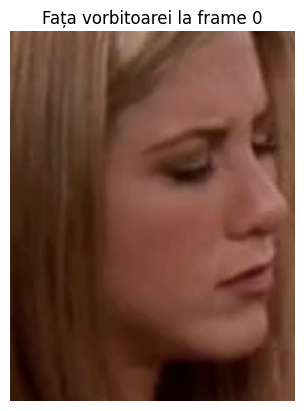

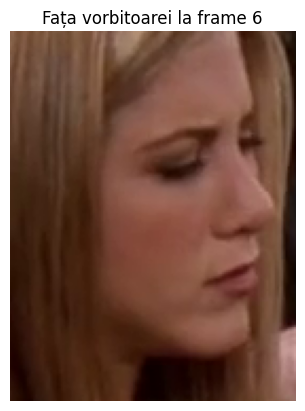

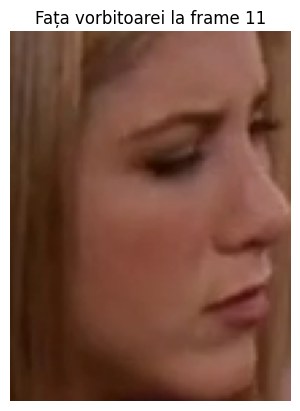

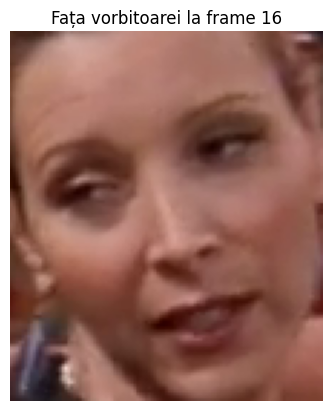

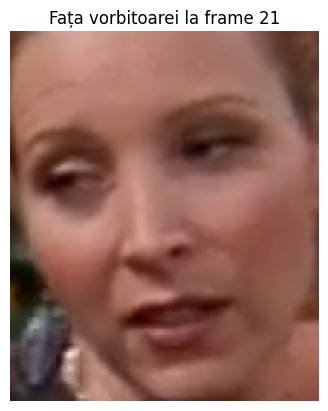

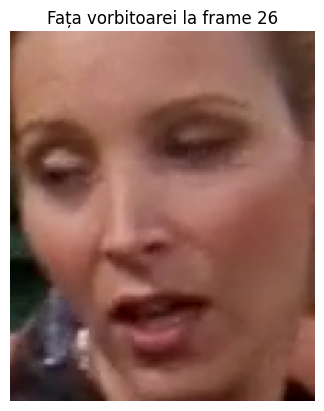

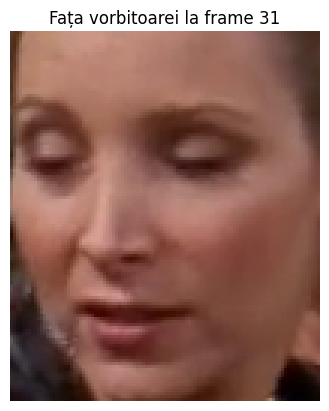

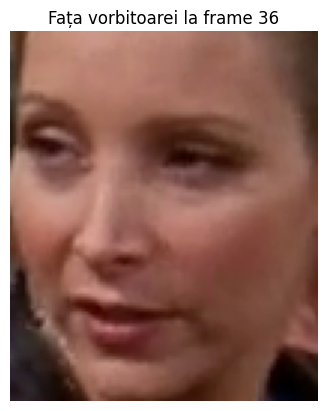

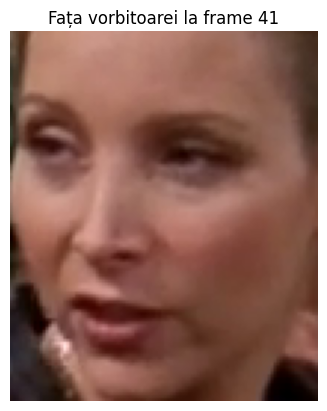

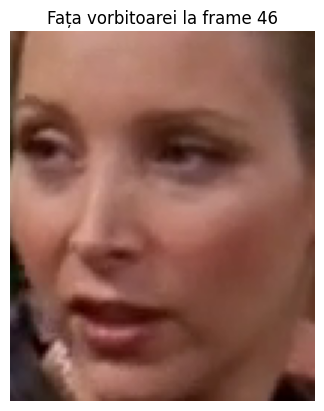

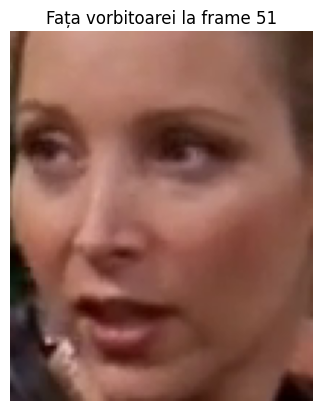

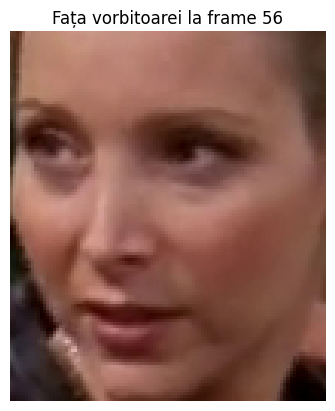

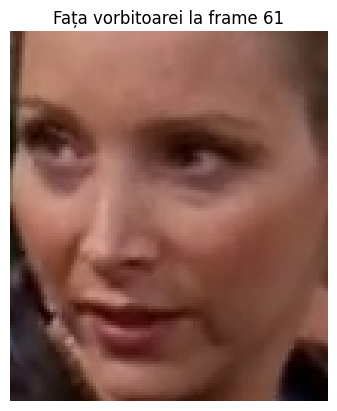

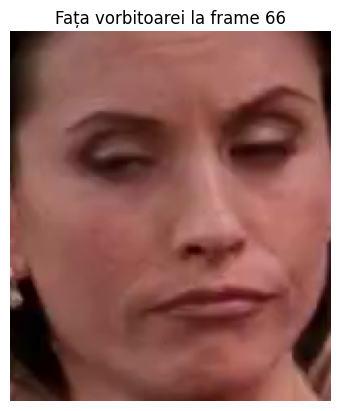

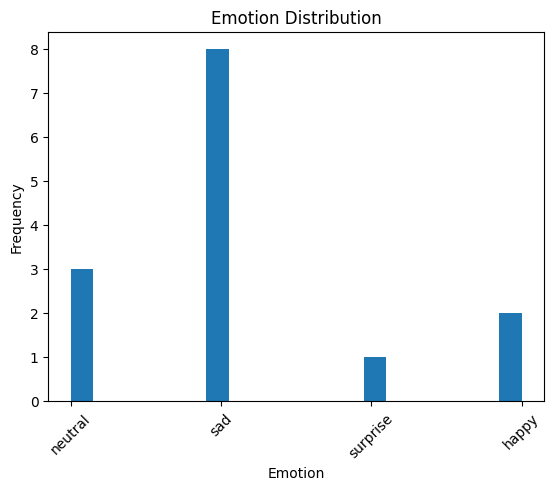

In [ ]:
path = Path.cwd().parent.parent

# path = path / 'data' / 'dev' / 'dev_splits_complete' / 'dia1_utt9.mp4' #o singura persoana barbat pozitie clara
path = path / 'data' / 'dev' / 'dev_splits_complete' / 'dia0_utt0.mp4' #3 persoane, pozitie clara vorbeste o singura persoana din dreapta


res = predict_emotions_in_video_for_speaker(path, face_mesh=face_mesh, plot_faces=True, frame_skip=5, verbose=True)

plt.hist(res, bins=20)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Distribution')
plt.xticks(rotation=45)
plt.show()